In [3]:
# Pandas is used for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, auc
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

def convert(data):
    number = preprocessing.LabelEncoder()
    data['operator'] = number.fit_transform(data.operator)
    data['methodReturn'] = number.fit_transform(data.methodReturn)
    data['isKilled'] = number.fit_transform(data.isKilled)
    return data

# Read in data and display first 5 rows
features = pd.read_csv('py_files/training_data.csv',encoding= 'unicode_escape')
#print(features)
#print('The shape of our features is:', features.shape)

#Convert string to float
features=convert(features)
#print(features)
#print('The shape of our features is:', features.shape) 

# Use numpy to convert to arrays
# Labels are the values we want to predict
labels = np.array(features['isKilled'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('isKilled', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [5]:
#Without validation set. Replicating paper

# Instantiate model with 100 decision trees default
rf = RandomForestClassifier(random_state = 5,criterion="entropy")
rf.fit(features, labels)
y_pred_train = rf.predict(features)
print(accuracy_score(labels, y_pred_train))
print(confusion_matrix(labels, y_pred_train))

0.980890923315304
[[462772   7418]
 [  3891 117732]]


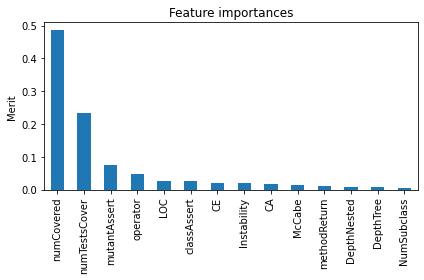

In [6]:
##Plot feature importance
feature_names = [f"features {i}" for i in range(features.shape[1])]
feature_names = ['DepthTree', 'NumSubclass', 'McCabe', 'LOC','DepthNested','CA','CE','Instability','numCovered','operator','methodReturn','numTestsCover','mutantAssert','classAssert']
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

#Feature importance
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Merit")
fig.tight_layout()

0.8573525846510249
Confusion_matrix:
 [[80740 12242]
 [ 8940 46570]]
(0.8573525846510249, 0.8573525846510249, 0.8573525846510249, None)
0.8573525846510249
[0.00000000e+00 1.80147721e-05 5.40443163e-05 ... 9.95892632e-01
 9.95946676e-01 1.00000000e+00] [0.         0.         0.         ... 0.37955733 0.37955733 1.        ] [1.99121212e+00 9.91212121e-01 9.88425000e-01 ... 3.33333333e-04
 2.85714286e-04 0.00000000e+00]
AUC:  0.9387149837842834
0.061285016215716706


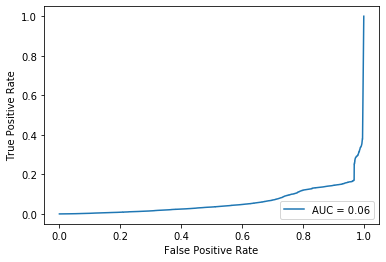

In [24]:
##Input test data
positive_prob = []
test = pd.read_csv('py_files/testing_data.csv',encoding= 'unicode_escape')

#Convert string to float
test=convert(test)

# ## Labels are the values we want to predict
test_labels = np.array(test['isKilled'])

# # Remove the labels from the features
# # axis 1 refers to the columns
test= test.drop('isKilled', axis = 1)
# # Saving feature names for later use
feature_list = list(test.columns)
# # Convert to numpy array
test = np.array(test)
y_pred_test = rf.predict(test)
#print("Predicted labels::", y_pred_test)
print(accuracy_score(test_labels, y_pred_test))
confusion = confusion_matrix(test_labels, y_pred_test)
print("Confusion_matrix:\n",confusion)
print(precision_recall_fscore_support(test_labels, y_pred_test, average='micro'))
print(f1_score(test_labels, y_pred_test, average='micro'))

# # #Get the probability of each predictions
predicted = rf.predict_proba(test)
#print(predicted)
# # #Take the positive predictictability i.e. survived for calculating ROC AUC
for i in predicted:
    positive_prob.append(i[1])
#print(positive_prob)
#Calculate ROC
fpr, tpr, thresholds = roc_curve(test_labels, positive_prob, pos_label=0)
print(fpr, tpr, thresholds)
try:
    print("AUC: ", roc_auc_score(test_labels, positive_prob))
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
except:
    pass
display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc)
display.plot()

In [6]:
##Validation set create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
rf = RandomForestClassifier(random_state = 5,criterion="entropy")
rf.fit(features, labels)
y_pred_train = rf.predict(X_test)
print(accuracy_score(y_test, y_pred_train))
print(confusion_matrix(y_test, y_pred_train))

(295906, 14) (295906,)
(295907, 14) (295907,)
0.980686499474497
[[231017   3748]
 [  1967  59175]]


In [16]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
split_index = [-1] * len(X_train) + [0]*len(X_test)
X = np.concatenate((X_train, X_test), axis =0)
y = np.concatenate((y_train, y_test), axis = 0)
pds = PredefinedSplit(test_fold = split_index)
pds.get_n_splits()

1

In [17]:
#Hyper parameter tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Criterion to getinformation gain
criterion = ['entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)

# Import the model we are using
rf = RandomForestClassifier()
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = pds, verbose=2, random_state=5, n_jobs = -1)
rf_random.fit(features, labels)
print(rf_random.best_params_)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['entropy']}
Fitting 1 folds for each of 300 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/prasanna/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 50.2min finished


{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}


In [18]:
# Running for different n_estimators to get a range for randomized search grid
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 20)]
for i in n_estimators:
    rf = RandomForestClassifier(n_estimators = i, random_state = 5,criterion="entropy")
    rf.fit(features, labels)
    y_pred_train = rf.predict(features)
    print(accuracy_score(labels, y_pred_train))
    print(confusion_matrix(labels, y_pred_train))

0.9808706466400704
[[462950   7240]
 [  4081 117542]]
0.980890923315304
[[462772   7418]
 [  3891 117732]]
0.9808943027611763
[[462727   7463]
 [  3844 117779]]
0.9808943027611763
[[462707   7483]
 [  3824 117799]]
0.9808943027611763
[[462685   7505]
 [  3802 117821]]
0.9808943027611763
[[462607   7583]
 [  3724 117899]]
0.9808943027611763
[[462645   7545]
 [  3762 117861]]
0.9808943027611763
[[462650   7540]
 [  3767 117856]]
0.9808943027611763
[[462637   7553]
 [  3754 117869]]
0.9808943027611763
[[462604   7586]
 [  3721 117902]]
0.9808943027611763
[[462605   7585]
 [  3722 117901]]
0.9808943027611763
[[462586   7604]
 [  3703 117920]]
0.9808943027611763
[[462564   7626]
 [  3681 117942]]
0.9808943027611763
[[462565   7625]
 [  3682 117941]]
0.9808943027611763
[[462533   7657]
 [  3650 117973]]
0.9808943027611763
[[462507   7683]
 [  3624 117999]]
0.9808943027611763
[[462507   7683]
 [  3624 117999]]
0.9808943027611763
[[462519   7671]
 [  3636 117987]]
0.9808943027611763
[[462510  

In [4]:
#Hyper parameter tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Criterion to getinformation gain
criterion = ['entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Criterion to getinformation gain
criterion = ['entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_sa_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)

# Import the model we are using
rf = RandomForestClassifier()
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=5, n_jobs = -1)
rf_random.fit(features, labels)
print(rf_random.best_params_)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['entropy']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/prasanna/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 83.2min finished


{'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}


In [25]:
best_entropy_with_cv = rf_random.best_estimator_
print(best_entropy_with_cv)
y_pred_test = rf.predict(test)
best_accuracy_entropy_with_cv = accuracy_score(test_labels, y_pred_test)
best_confusion_entropy_with_cv = confusion_matrix(test_labels, y_pred_test)
print(best_accuracy_entropy_with_cv)
print(best_confusion_entropy_with_cv )

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=150)
0.8573525846510249
[[80740 12242]
 [ 8940 46570]]


In [27]:
rf = RandomForestClassifier(n_estimators=250, min_samples_split=10, min_samples_leaf=4, max_features="auto", max_depth= 10, bootstrap=True,random_state = 5,criterion="entropy")
rf.fit(features, labels)
y_pred_test = rf.predict(test)
#print("Predicted labels::", y_pred_test)
best_accuracy_entropy_with_kfold = accuracy_score(test_labels, y_pred_test)
best_confusion_entropy_with_kfold = confusion_matrix(test_labels, y_pred_test)
print(best_accuracy_entropy_with_kfold)
print(best_confusion_entropy_with_kfold)

0.8568677100449856
[[80203 12779]
 [ 8475 47035]]
